# Implementing Machine Learning Regression Algorithms

In [670]:
# Import libraries and perform basic filtering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit, StratifiedShuffleSplit, GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, \
AdaBoostRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel, f_regression, SelectKBest
from sklearn.model_selection import learning_curve, StratifiedKFold, KFold

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict

pd.set_option('display.max_columns', None)

df = pd.DataFrame.from_csv('data.csv').set_index(['Name', 'Season']).reset_index()
df = df.loc[df['MIN'] >= np.log(100)]
df = df.loc[df['Drafted'] != 2016]
df['Valid'] = df['Drafted'] - df['Season']
df = df.loc[df['Valid'] >= 0]
df.replace(np.inf, np.nan, inplace=True)
print len(df)
print len(df.columns)
df.head()

2525
76


,Name,Season,FG% 2pt Jumpers,Max_Vert,NS_Vert,IS_Score,P_Score,D_Score,OS_Score,%assisted at rim,3PA,FGA,FGM,WtHr,FG%,FG% at rim,Height,WHr,%of shots 3pt,3P%,PTS,0,FT%,%assisted 3s,3PM,FTr,FGatRim,FTA,% shots 2pt J,%assisted 2pt J,TOV,FTM,% shots at rim,PF,STL,2ptJUnAssisted,3ptJUnAssisted,RimUnAssisted,TRB,Weight,Agility,DEF,2ptJ,Stocks,RSB,RSB2,OFF,ATr,Speed,BLK,AST,Stocks2,MIN,2P%,2PA,2PM,3PAr,A_Score,Age,Born,Drafted,FGM_z,Pick,Url,WSPredict,WSTOT,Wingspan,Vert_adj,Move_adj,OS,IS,D,P,IS2,OS2,Valid
4,A.J. Price,2007.0,NaN,31.0,26.0,10.247271,3.790970,1.751379,2.732442,NaN,4.231316,14.464706,4.968160,0.468085,0.204570,NaN,2577.726130,1.035351,NaN,0.109349,49.823063,NaN,0.328509,NaN,0.991531,0.337637,NaN,4.613243,NaN,NaN,2.337487,1.529453,NaN,1.819128,1.401573,NaN,NaN,NaN,2.292789,9.380832,1.794436,1.841145,NaN,1.438955,2.706930,1.047152,1.237424,1.269680,2.205613,0.570841,1.590088,0.675807,5.917549,0.398620,9.936978,3.848413,0.296459,6.098541,20.233562,1986.766438,2009.0,0.653459,52.0,http://basketball.realgm.com/player/AJ-Price/S...,1.660,4.722121,192.405,806.00,3.95783,1.826428,9.489956,1.805357,3.427770,9.489956,1.826428,2.0
5,A.J. Price,2008.0,NaN,31.0,26.0,10.247271,3.790970,1.751379,2.732442,NaN,4.739364,14.456359,5.612916,0.468085,0.245469,NaN,2577.726130,1.035351,NaN,0.171835,61.304881,NaN,0.415161,NaN,1.353728,0.335919,NaN,4.587792,NaN,NaN,2.097470,1.584962,NaN,1.773058,1.263290,NaN,NaN,NaN,2.140946,9.380832,1.794436,1.911775,NaN,1.306616,2.508165,0.902482,0.993433,1.409480,2.205613,0.577650,1.659984,0.649257,6.272877,0.428596,9.303272,3.873936,0.332246,6.098541,21.233562,1986.766438,2009.0,0.653459,52.0,http://basketball.realgm.com/player/AJ-Price/S...,1.660,4.722121,192.405,806.00,3.95783,2.255721,9.667930,1.759769,3.554185,9.667930,2.255721,1.0
6,A.J. Price,2009.0,NaN,31.0,26.0,10.247271,3.790970,1.751379,2.732442,NaN,6.711250,16.120784,5.837000,0.468085,0.221445,NaN,2577.726130,1.035351,NaN,0.195394,66.385385,NaN,0.374805,NaN,1.874534,0.283446,NaN,4.200818,NaN,NaN,2.373968,1.468735,NaN,1.598260,0.933707,NaN,NaN,NaN,2.172164,9.380832,1.794436,2.002407,NaN,0.933707,2.364341,0.000000,0.916389,1.258134,2.205613,0.000000,1.587295,0.000000,6.320768,0.368901,8.619957,3.089467,0.421906,6.098541,22.233562,1986.766438,2009.0,0.653459,52.0,http://basketball.realgm.com/player/AJ-Price/S...,1.660,4.722121,192.405,806.00,3.95783,2.492122,9.124538,1.319477,3.423950,9.124538,2.492122,0.0
8,Aaron Brooks,2004.0,NaN,39.5,32.5,13.914187,4.269258,2.198977,3.656265,NaN,5.008133,9.601981,3.163645,0.398907,0.192015,NaN,2475.578114,1.083414,NaN,0.171137,28.406942,NaN,0.489304,NaN,1.409835,0.253191,NaN,2.544157,NaN,NaN,2.452127,1.099090,NaN,2.387062,1.112177,NaN,NaN,NaN,1.968078,8.544004,1.788854,1.752383,NaN,1.144421,2.276627,0.590427,0.946144,1.094204,2.177433,0.519368,1.443498,0.547724,5.600272,0.334841,3.890951,1.265792,0.528583,10.021181,18.964384,1985.035616,2007.0,0.653459,26.0,http://basketball.realgm.com/player/Aaron-Broo...,4.475,18.985319,193.040,1283.75,3.89511,2.218345,8.418384,1.369387,3.154145,8.418384,2.218345,3.0
9,Aaron Brooks,2005.0,NaN,39.5,32.5,13.914187,4.269258,2.198977,3.656265,NaN,5.707486,14.084487,5.361113,0.398907,0.238760,NaN,2475.578114,1.083414,NaN,0.173234,62.215937,NaN,0.625026,NaN,1.564564,0.326899,NaN,4.378182,NaN,NaN,2.631032,1.643757,NaN,2.042711,1.102450,NaN,NaN,NaN,2.053648,8.544004,1.788854,1.833364,NaN,1.181293,2.369161,0.960708,0.967088,1.180048,2.177433,0.651409,1.564805,0.683963,6.100319,0.429060,7.723067,3.219410,0.410679,10.021181,19.964384,1985.035616,2007.0,0.653459,26.0,http://basketball.realgm.com/player/Aaron-Broo...,4.475,18.985319,193.040,1283.75,3.89511,2.488731,9.650509,1.572144,3.393502,9.650509,2.488731,2.0


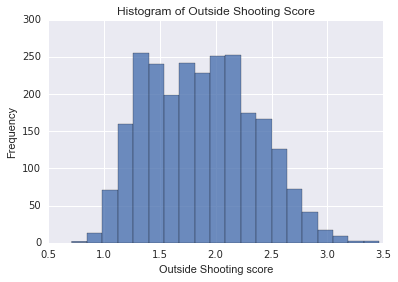

In [716]:
# Plot Meta-Feature

plt.figure()
plt.title('Histogram of Outside Shooting Score')
plt.xlabel('Outside Shooting score')
df['OS2'].plot.hist(bins=20, alpha=0.8)

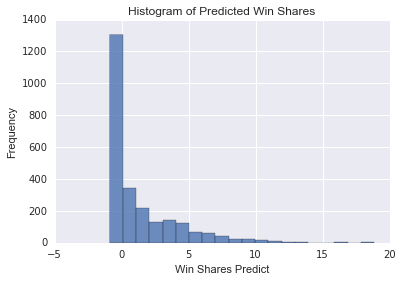

In [671]:
# Plot the target

plt.figure()
plt.title('Histogram of Predicted Win Shares')
plt.xlabel('Win Shares Predict')
df['WSPredict'].plot.hist(bins=20, alpha=0.8)

## Feature Examination

In [680]:
possible = list(df[['2P%', '2PA', '2PM', 'AST', 'ATr', 'Age', 'Agility', 'BLK', 'DEF', 'FG%', 'FGA', 'FGM', 'FT%', 'FTA', \
            'FTr', 'Height', 'Max_Vert', 'Vert_adj', 'NS_Vert', 'Move_adj', 'OFF', 'PTS', 'STL', 'Speed', 'WHr', \
            'Weight', 'Wingspan', 'OS2', 'IS2', 'D', 'TRB', 'P']])

target_cols = list(df[['WSPredict']])

X = df[possible].fillna(0)
y = df[target_cols]
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=possible)
X.head()

groups = list(df['Url'])
group_kfold = GroupShuffleSplit(n_splits=1000)
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    
# Use Random Forest for feature importances
def FeatureComparison(X_train, X_test, Y_train, Y_test):
    reg = RandomForestRegressor(max_features=None)
    reg.fit(X_train, Y_train)
    feature_names = sorted([(possible[i], reg.feature_importances_[i]) for i in range(len(possible))], \
                           key=lambda x: x[1], reverse=True)
    print "Regressor: Random Forest"
    print "Feature Names and Importance Scores:", feature_names
    
FeatureComparison(X_train, X_test, Y_train, Y_test)

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Regressor: Random Forest
Feature Names and Importance Scores: [('Age', 0.091124571366881263), ('D', 0.079145183038525468), ('PTS', 0.061996518904678388), ('ATr', 0.047198869944968927), ('STL', 0.040458182069426522), ('FGM', 0.039859842373263552), ('Wingspan', 0.039626671633404151), ('FT%', 0.038318043063991121), ('Speed', 0.03740932648898395), ('WHr', 0.036468372832073173), ('OS2', 0.034594517132207292), ('FGA', 0.033872994906176887), ('IS2', 0.032875648499539875), ('FTr', 0.032270170366259218), ('FG%', 0.028356892694984637), ('Move_adj', 0.02745498529763803), ('Weight', 0.026307799362765644), ('Vert_adj', 0.023747383466920284), ('FTA', 0.023016551243648486), ('Agility', 0.022746805961403289), ('Max_Vert', 0.021697722874563036), ('AST', 0.020982978296230314), ('DEF', 0.02089278411968664), ('NS_Vert', 0.02079591172606176), ('BLK', 0.020039918048842153), ('P', 0.019818003142524701), ('2P%', 0.017536914392217724), ('TRB', 0.013641145022860643), ('OFF', 0.013436799532352186), ('Height', 0.

## Perform Linear Regression

In [681]:
feature_cols = list(df[['Age', 'PTS', 'STL', 'BLK', 'AST', 'ATr', 'TOV', 'PF', 'OS2', 'IS2', 'WHr', 'TRB']])
target_cols = list(df[['WSPredict']])

X = df[feature_cols].fillna(np.mean(df[feature_cols]))
y = df[target_cols]
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=feature_cols)
X.head()

,Age,PTS,STL,BLK,AST,ATr,TOV,PF,OS2,IS2,WHr,TRB
0,0.288846,0.295981,0.642971,0.338844,0.796743,0.751882,0.496275,0.253530,0.405456,0.531208,0.416997,0.325872
1,0.395519,0.371024,0.579534,0.342885,0.850582,0.860577,0.428159,0.236098,0.561262,0.548230,0.416997,0.275910
2,0.502192,0.404229,0.428338,0.000000,0.794592,0.742906,0.506629,0.169960,0.647060,0.496258,0.416997,0.286182
3,0.153458,0.156009,0.510211,0.308290,0.683830,0.615449,0.528810,0.468421,0.547697,0.428719,0.573306,0.219030
4,0.260132,0.376978,0.505748,0.386668,0.777268,0.682193,0.579583,0.338128,0.645830,0.546563,0.573306,0.247185


In [682]:
lr = linear_model.LinearRegression()
lr.fit(X, y)

predicted = cross_val_predict(lr, X, y, groups=groups, cv=100)
RMSE = mean_squared_error(y, predicted)**0.5
print "RMSE:", RMSE

df['LinearPred'] = predicted

# Sort by linear prediction
df_sort = df.sort('LinearPred', ascending=False)
df_sort[0:50]

RMSE: 2.43295630424


C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Name,Season,FG% 2pt Jumpers,Max_Vert,NS_Vert,IS_Score,P_Score,D_Score,OS_Score,%assisted at rim,3PA,FGA,FGM,WtHr,FG%,FG% at rim,Height,WHr,%of shots 3pt,3P%,PTS,0,FT%,%assisted 3s,3PM,FTr,FGatRim,FTA,% shots 2pt J,%assisted 2pt J,TOV,FTM,% shots at rim,PF,STL,2ptJUnAssisted,3ptJUnAssisted,RimUnAssisted,TRB,Weight,Agility,DEF,2ptJ,Stocks,RSB,RSB2,OFF,ATr,Speed,BLK,AST,Stocks2,MIN,2P%,2PA,2PM,3PAr,A_Score,Age,Born,Drafted,FGM_z,Pick,Url,WSPredict,WSTOT,Wingspan,Vert_adj,Move_adj,OS,IS,D,P,IS2,OS2,Valid,LinearPred
2864,Michael Beasley,2008.0,NaN,35.000000,30.000000,16.521516,3.687374,3.092687,2.980596,NaN,3.132161,22.354925,10.563953,0.514423,0.329718,NaN,2999.818661,1.043543,NaN,0.178867,145.231024,NaN,0.463685,NaN,1.012676,0.396233,NaN,7.504215,NaN,NaN,2.396802,2.240797,NaN,2.223844,1.236526,NaN,NaN,NaN,3.976642,10.344080,1.800000,3.303436,NaN,1.869452,4.394147,6.894384,1.705109,0.773821,2.210239,1.184098,1.101868,1.316708,6.253829,0.502029,19.548787,9.534930,0.141994,12.668501,18.978082,1989.021918,2008.0,0.653459,2.0,http://basketball.realgm.com/player/Michael-Be...,3.870000,13.159968,213.995,1050.000000,3.978430,2.504783,12.260396,2.552364,2.506730,12.260396,2.504783,0.0,6.320942
2429,Kevin Durant,2007.0,NaN,33.500000,26.000000,20.797851,4.441488,3.904443,4.663836,NaN,5.773411,21.656504,9.082920,0.529126,0.275542,NaN,2956.656219,1.144728,NaN,0.196854,123.890533,NaN,0.543338,NaN,1.680606,0.340509,NaN,6.297150,NaN,NaN,2.212727,2.047183,NaN,1.887696,1.439656,NaN,NaN,NaN,3.610993,10.440307,1.857418,3.106656,NaN,2.043678,4.149204,7.540662,1.514338,0.813039,2.290962,1.204376,1.113851,1.445078,6.441744,0.449464,15.568571,6.798485,0.270173,15.882844,18.256621,1988.743379,2007.0,0.653459,2.0,http://basketball.realgm.com/player/Kevin-Dura...,18.845000,125.591593,225.425,871.000000,4.255272,2.643240,11.074864,2.711778,2.517013,11.074864,2.643240,0.0,5.864192
2442,Kevin Love,2008.0,NaN,35.000000,29.500000,18.493487,4.811001,3.703366,4.589578,NaN,2.714309,15.792409,7.842218,0.548077,0.355135,NaN,2999.818661,1.025019,NaN,0.161465,101.880403,NaN,0.451218,NaN,0.863646,0.486351,NaN,7.097585,NaN,NaN,2.073501,2.149664,NaN,2.064994,0.993398,NaN,NaN,NaN,4.018583,10.677078,1.794436,3.286017,NaN,1.741728,4.379797,5.711251,1.753384,1.033570,2.217469,1.196100,1.307315,1.192145,6.359574,0.545666,13.192975,6.994205,0.174184,13.785228,19.316895,1988.683105,2008.0,0.653459,5.0,http://basketball.realgm.com/player/Kevin-Love...,13.523788,75.731831,211.455,1032.500000,3.979106,2.247069,11.373297,2.432597,2.876213,11.373297,2.247069,0.0,5.650636
365,Blake Griffin,2009.0,NaN,35.500000,32.000000,19.436935,4.673179,3.581850,2.793872,NaN,0.278819,16.673339,9.699940,0.548077,0.450440,NaN,2999.818661,1.025019,NaN,0.147312,116.132257,NaN,0.203297,NaN,0.149901,0.528315,NaN,8.030349,NaN,NaN,2.639871,2.042547,NaN,2.218176,1.155024,NaN,NaN,NaN,4.288565,10.677078,1.811077,3.695890,NaN,1.654259,4.596559,5.866152,1.691209,0.928860,2.202960,1.088241,1.306761,1.169555,6.367329,0.590632,17.111135,9.818934,0.016947,15.834146,19.792237,1989.207763,2009.0,0.653459,1.0,http://basketball.realgm.com/player/Blake-Grif...,11.757879,62.161715,211.455,1136.000000,3.989731,1.691843,12.359489,2.623377,2.907404,12.359489,1.691843,0.0,5.390501
218,Andrew Bogut,2005.0,NaN,33.500000,27.500000,17.506189,4.325462,3.656871,1.569901,NaN,0.840003,17.886112,9.854050,0.553991,0.414823,NaN,3108.632658,1.056720,NaN,0.165587,112.091360,NaN,0.331374,NaN,0.363154,0.381157,NaN,6.106816,NaN,NaN,2.450238,1.847000,NaN,2.150564,1.123126,NaN,NaN,NaN,4.106866,10.862780,1.873499,3.453141,NaN,1.916490,4.532028,7.162826,1.711460,0.993962,2.274284,1.246157,1.341813,1.320648,6.416732,0.567456,17.690369,9.752983,0.047595,13.481638,20.092694,1984.907306,2005.0,0.653459,1.0,http://basketball.realgm.com/player/Andrew-Bog...,7.040000,52.023997,220.980,921.250000,4.260869,1.757609,12.309118,2.596386,2.961627,12.309118,1.757609,0.0,5.348681
3327,Rodney Carney,2004.0,NaN,38.500000,32.000000,10.480659,2.428807,1.921284,2

In [683]:
# Determine Error
df['LinearErr'] = df['WSPredict'] - df['LinearPred']

## Implement Machine Learning Algorithm to Estimate Error

In [684]:
feature_cols = list(df[['Move_adj', 'Vert_adj', 'Height', 'WHr', 'WtHr', 'OS2', 'D', 'IS2', 'P', 'FTr', 'LinearPred']])
X = df[feature_cols].fillna(0)
y = df['LinearErr']
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=feature_cols)

groups = list(df['Url'])
group_kfold = GroupShuffleSplit(n_splits=1000)
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]

In [685]:
RMSE = make_scorer(mean_squared_error, greater_is_better = False)

N = float(len(df))
p = float(len(feature_cols))
targets = 1

def RandomForest(X_train, X_test, Y_train, Y_test):
    reg = RandomForestRegressor(max_features=None)
    reg.fit(X_train, Y_train)
    feature_names = sorted([(feature_cols[i], reg.feature_importances_[i]) for i in range(len(feature_cols))], \
                           key=lambda x: x[1], reverse=True)
    
    pred = reg.predict(X_test)
    Y_test = Y_test.values
    r2 = reg.score(X_test, Y_test)
    adj_r2 = 1 - ((1 - r2)*(N - 1)/(N - p - 1))
    print "Regressor: Random Forest"
    print "Feature Names and Importance Scores:", feature_names
    print 'R-Squared:', r2
    print 'Adj. R-Squared:', adj_r2
    RMSE = mean_squared_error(Y_test, pred)**0.5
    print "RMSE:", RMSE
    
def Tree(X_train, X_test, Y_train, Y_test):
    reg = DecisionTreeRegressor()
    reg.fit(X_train, Y_train)
    feature_names = sorted([(feature_cols[i], reg.feature_importances_[i]) for i in range(len(feature_cols))], \
                           key=lambda x: x[1], reverse=True)
    
    pred = reg.predict(X_test)
    Y_test = Y_test.values
    r2 = reg.score(X_test, Y_test)
    adj_r2 = 1 - ((1 - r2)*(N - 1)/(N - p - 1))
    print "Regressor: Decision Tree"
    print "Feature Names and Importance Scores:", feature_names
    print 'R-Squared:', r2
    print 'Adj. R-Squared:', adj_r2
    RMSE = mean_squared_error(Y_test, pred)**0.5
    print "RMSE:", RMSE
    print
    
def ExtraTrees(X_train, X_test, Y_train, Y_test):
    reg = ExtraTreesRegressor(max_features=None)
    reg.fit(X_train, Y_train)
    feature_names = sorted([(feature_cols[i], reg.feature_importances_[i]) for i in range(len(feature_cols))], \
                           key=lambda x: x[1], reverse=True)
    
    pred = reg.predict(X_test)
    Y_test = Y_test.values
    r2 = reg.score(X_test, Y_test)
    adj_r2 = 1 - ((1 - r2)*(N - 1)/(N - p - 1))
    print "Regressor: Extra Trees Regressor"
    print "Feature Names and Importance Scores:", feature_names
    print 'R-Squared:', r2
    print 'Adj. R-Squared:', adj_r2
    RMSE = mean_squared_error(Y_test, pred)**0.5
    print "RMSE:", RMSE
    print
    
def NN(X_train, X_test, Y_train, Y_test):
    reg = KNeighborsRegressor(n_neighbors=20, weights='distance')
    reg.fit(X_train, Y_train)
    pred = reg.predict(X_test)
    Y_test = Y_test.values
    r2 = reg.score(X_test, Y_test)
    adj_r2 = 1 - ((1 - r2)*(N - 1)/(N - p - 1))
    print "Regressor: Nearest Neighbor"
    print 'R-Squared:', r2
    print 'Adj. R-Squared:', adj_r2
    RMSE = mean_squared_error(Y_test, pred)**0.5
    print "RMSE:", RMSE
    print
    
def Linear(X_train, X_test, Y_train, Y_test):
    reg = linear_model.LinearRegression(fit_intercept=True)
    reg.fit(X_train, Y_train)
    pred = reg.predict(X_test)
    Y_test = Y_test.values
    r2 = reg.score(X_test, Y_test)
    adj_r2 = 1 - ((1 - r2)*(N - 1)/(N - p - 1))
    print "Regressor: Linear Regression"
    print 'R-Squared:', r2
    print 'Adj. R-Squared:', adj_r2
    RMSE = mean_squared_error(Y_test, pred)**0.5
    print "RMSE:", RMSE
    print
    
def Gradient(X_train, X_test, Y_train, Y_test):
    reg = GradientBoostingRegressor()
    reg.fit(X_train, Y_train)
    pred = reg.predict(X_test)
    Y_test = Y_test.values
    r2 = reg.score(X_test, Y_test)
    adj_r2 = 1 - ((1 - r2)*(N - 1)/(N - p - 1))
    print "Regressor: Gradient Boost"
    print 'R-Squared:', r2
    print 'Adj. R-Squared:', adj_r2
    RMSE = mean_squared_error(Y_test, pred)**0.5
    print "RMSE:", RMSE
    print
    
def Bagging(X_train, X_test, Y_train, Y_test):
    reg = BaggingRegressor()
    reg.fit(X_train, Y_train)
    pred = reg.predict(X_test)
    Y_test = Y_test.values
    r2 = reg.score(X_test, Y_test)
    adj_r2 = 1 - ((1 - r2)*(N - 1)/(N - p - 1))
    print "Regressor: Bagging"
    print 'R-Squared:', r2
    print 'Adj. R-Squared:', adj_r2
    RMSE = mean_squared_error(Y_test, pred)**0.5
    print "RMSE:", RMSE
    print
    
Linear(X_train, X_test, Y_train, Y_test)
RandomForest(X_train, X_test, Y_train, Y_test)
ExtraTrees(X_train, X_test, Y_train, Y_test)
NN(X_train, X_test, Y_train, Y_test)
Bagging(X_train, X_test, Y_train, Y_test)
Gradient(X_train, X_test, Y_train, Y_test)
Tree(X_train, X_test, Y_train, Y_test)

Regressor: Linear Regression
R-Squared: 0.0210402429626
Adj. R-Squared: 0.0167551027607
RMSE: 2.49343906677

Regressor: Ridge Regression
R-Squared: 0.0210460008386
Adj. R-Squared: 0.0167608858403
RMSE: 2.49343173402

Regressor: Lasso Regression
R-Squared: -6.68918168576e-05
Adj. R-Squared: -0.00444442297881
RMSE: 2.52017596235

Regressor: Random Forest
Feature Names and Importance Scores: [('LinearPred', 0.2079721239238928), ('Move_adj', 0.13548470588138486), ('WHr', 0.092571653588958608), ('P', 0.083902546291511601), ('Vert_adj', 0.08102008403860872), ('D', 0.079424328121704454), ('Height', 0.077071896078163005), ('OS2', 0.072723995934093788), ('WtHr', 0.063462007150877076), ('IS2', 0.054887493804489131), ('FTr', 0.051479165186315956)]
R-Squared: -0.113589891601
Adj. R-Squared: -0.118464339992
RMSE: 2.65937131546
Regressor: Extra Trees Regressor
Feature Names and Importance Scores: [('LinearPred', 0.14436252068988992), ('Height', 0.12685603860454844), ('Move_adj', 0.10509711752034648)

## Hyperparameter Optimization

In [686]:
# Best performing Regressors
rfc = RandomForestRegressor()
dtc = DecisionTreeRegressor()
nn = KNeighborsRegressor(weights='distance', n_neighbors=25)
etc = ExtraTreesRegressor(n_estimators=50, min_samples_split=4, min_samples_leaf=4)
gb = GradientBoostingRegressor()
rr = linear_model.Ridge()
bag = BaggingRegressor()

RMSE = make_scorer(mean_squared_error, greater_is_better = False)

# GridSearchCV is used to compare parameters. Parameters were tuned manually
# based on their performance using an increasing amount of folds. The
# following represents the final iteration of tuning.
params_etc = {'etc__n_estimators': [50],
             'etc__min_samples_split': [2, 3, 4, 5],
             'etc__min_impurity_split': [1e-07],
             'etc__min_samples_leaf': [2, 3, 4],
             'etc__min_weight_fraction_leaf': [0],
             'kbest__score_func': [f_regression],
             'kbest__k': ['all']}

params_rfc = {'rfc__n_estimators': [50],
             'rfc__max_features': [None],
             'rfc__max_depth': [None],
             'rfc__min_samples_split': [3, 4],
             'rfc__min_samples_leaf': [2, 3],
             'rfc__min_weight_fraction_leaf': [0],
             'kbest__score_func': [f_regression],
             'kbest__k': ['all']}

params_gb = {'gb__loss': ['ls'],
             'gb__learning_rate': [0.2, 0.4, 0.6],
             'gb__alpha': [0.9, 0.8, 0.7]}
             

params_nn = {'nn__n_neighbors': [15, 20, 25, 100],
             'nn__weights': ['distance'],
             'nn__leaf_size': [3, 5, 7],
             'kbest__k': ['all']}

params_bag = {'bag__base_estimator': [etc, nn],
             'bag__n_estimators': [50]}

params_rr = {'kbest__score_func': [f_regression],
             'kbest__k': ['all']}

params_lr = {'kbest__score_func': [f_regression],
             'kbest__k': ['all']}

parameters = [params_bag]

clf_list = [('bag', bag)]

estimators = []
for clf_i in range(len(clf_list)):
    cv = GroupShuffleSplit(n_splits=10, random_state=2)
    kbest2 = SelectKBest(f_regression, k='all')
    pipeline = Pipeline([('kbest', kbest2), (clf_list[clf_i])])
    gs = GridSearchCV(pipeline, scoring=RMSE, cv=cv, param_grid=parameters[clf_i])
    gs.fit(X, y, groups)
    pred = gs.predict(X)
    clf = gs.best_estimator_
    estimators.append(clf)
    print "Best Estimator:", clf
    print "Best RMSE Score: %.3f" % (gs.best_score_*-1)**0.5
    print

Best Estimator: Pipeline(steps=[('kbest', SelectKBest(k='all', score_func=<function f_regression at 0x0000000008F14E48>)), ('bag', BaggingRegressor(base_estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_...estimators=50, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False))])
Best RMSE Score: 2.493



In [689]:
X2 = X.values
y2 = y.values

In [691]:
# Predict Error
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(estimators[0], X2, y2, groups, cv=10)
df['Prediction'] = predicted

In [692]:
df.sort('Prediction', ascending=False)

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Name,Season,FG% 2pt Jumpers,Max_Vert,NS_Vert,IS_Score,P_Score,D_Score,OS_Score,%assisted at rim,3PA,FGA,FGM,WtHr,FG%,FG% at rim,Height,WHr,%of shots 3pt,3P%,PTS,0,FT%,%assisted 3s,3PM,FTr,FGatRim,FTA,% shots 2pt J,%assisted 2pt J,TOV,FTM,% shots at rim,PF,STL,2ptJUnAssisted,3ptJUnAssisted,RimUnAssisted,TRB,Weight,Agility,DEF,2ptJ,Stocks,RSB,RSB2,OFF,ATr,Speed,BLK,AST,Stocks2,MIN,2P%,2PA,2PM,3PAr,A_Score,Age,Born,Drafted,FGM_z,Pick,Url,WSPredict,WSTOT,Wingspan,Vert_adj,Move_adj,OS,IS,D,P,IS2,OS2,Valid,LinearPred,LinearErr,Prediction
2864,Michael Beasley,2008.0,NaN,35.000000,30.000000,16.521516,3.687374,3.092687,2.980596,NaN,3.132161,22.354925,10.563953,0.514423,0.329718,NaN,2999.818661,1.043543,NaN,0.178867,145.231024,NaN,0.463685,NaN,1.012676,0.396233,NaN,7.504215,NaN,NaN,2.396802,2.240797,NaN,2.223844,1.236526,NaN,NaN,NaN,3.976642,10.344080,1.800000,3.303436,NaN,1.869452,4.394147,6.894384,1.705109,0.773821,2.210239,1.184098,1.101868,1.316708,6.253829,0.502029,19.548787,9.534930,0.141994,12.668501,18.978082,1989.021918,2008.0,0.653459,2.0,http://basketball.realgm.com/player/Michael-Be...,3.870000,13.159968,213.995,1050.000000,3.978430,2.504783,12.260396,2.552364,2.506730,12.260396,2.504783,0.0,6.320942,-2.450942,3.344026
2442,Kevin Love,2008.0,NaN,35.000000,29.500000,18.493487,4.811001,3.703366,4.589578,NaN,2.714309,15.792409,7.842218,0.548077,0.355135,NaN,2999.818661,1.025019,NaN,0.161465,101.880403,NaN,0.451218,NaN,0.863646,0.486351,NaN,7.097585,NaN,NaN,2.073501,2.149664,NaN,2.064994,0.993398,NaN,NaN,NaN,4.018583,10.677078,1.794436,3.286017,NaN,1.741728,4.379797,5.711251,1.753384,1.033570,2.217469,1.196100,1.307315,1.192145,6.359574,0.545666,13.192975,6.994205,0.174184,13.785228,19.316895,1988.683105,2008.0,0.653459,5.0,http://basketball.realgm.com/player/Kevin-Love...,13.523788,75.731831,211.455,1032.500000,3.979106,2.247069,11.373297,2.432597,2.876213,11.373297,2.247069,0.0,5.650636,7.873152,3.204982
578,Cameron Payne,2015.0,0.456,35.500000,30.000000,6.961844,2.442287,1.377380,1.865586,0.153,7.371172,20.858489,8.452114,0.439791,0.261651,0.497668,2639.672518,1.081931,0.258696,0.177453,107.542082,NaN,0.487443,0.113165,1.915518,0.287120,1.894836,5.162386,0.516119,0.278646,2.248083,1.760585,0.423084,2.049353,1.575392,19.825696,27.071053,15.300840,2.238911,9.165151,1.811077,2.065349,1.984376,1.761342,2.848693,2.778333,0.932721,1.398195,2.198969,0.887523,1.688488,1.113971,6.325255,0.457829,12.767728,5.679175,0.358139,5.695964,20.397489,1994.602511,2015.0,0.653459,14.0,http://basketball.realgm.com/player/Cameron-Pa...,1.769724,1.290213,201.295,1065.000000,3.982503,2.615543,10.515243,2.123244,3.613220,8.939849,2.843645,0.0,4.084859,-2.315135,2.941918
2774,Marcus Smart,2014.0,0.307,36.000000,33.000000,11.697892,4.154197,2.869677,2.437475,0.310,5.824834,16.110310,6.042197,0.518135,0.232940,0.522838,2681.241690,1.105731,0.277066,0.125337,83.761443,NaN,0.385828,0.140283,1.349367,0.493338,2.628806,7.307966,0.329952,0.438362,2.290274,2.134867,0.589067,2.388224,1.868243,10.601425,24.060727,19.018000,2.764213,10.000000,1.805547,2.428807,1.061912,2.048473,3.440511,4.338898,1.219151,1.267218,2.194295,0.916616,1.576990,1.252864,6.228511,0.458520,9.699402,4.320880,0.366419,10.577818,19.819635,1994.180365,2014.0,0.653459,6.0,http://basketball.realgm.com/player/Marcus-Sma...,4.881334,7.768511,206.375,1188.000000,3.961903,2.121253,10.019811,2.399854,3.400831,9.811428,1.885696,0.0,3.872084,1.009251,2.936793
559,C.J. McCollum,2013.0,0.426,38.500000,32.000000,3.190531,4.817066,2.523206,3.400560,0.382,6.169588,21.976312,9.658619,0.450262,0.295926,0.405668,2639.672518,1.056434,0.189571,0.284149,138.528441,NaN,0.611960,0.197926,2.121269,0.328300,2.750515,6.138482,0.456016,0.226417,2.369566,2.052812,0.565685,1.890089,1.345182,18.114898,24.755680,19.593480,2.607593,9.273618,1.822087,2.351389,1.812741,1.495086,3.005799,2.288798,1.103946,1.078459,2.207598,0.807780,1.411528,0.936880,5.228431,0.432717,15.416005,6.481036,0.284511,6.797472,21.284018,1991.715

In [693]:
# Add the error prediction to the linear prediction
df['SecondPred'] = df['Prediction'] + df['LinearPred']

In [694]:
df.sort('SecondPred', ascending=False)[0:50]

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Name,Season,FG% 2pt Jumpers,Max_Vert,NS_Vert,IS_Score,P_Score,D_Score,OS_Score,%assisted at rim,3PA,FGA,FGM,WtHr,FG%,FG% at rim,Height,WHr,%of shots 3pt,3P%,PTS,0,FT%,%assisted 3s,3PM,FTr,FGatRim,FTA,% shots 2pt J,%assisted 2pt J,TOV,FTM,% shots at rim,PF,STL,2ptJUnAssisted,3ptJUnAssisted,RimUnAssisted,TRB,Weight,Agility,DEF,2ptJ,Stocks,RSB,RSB2,OFF,ATr,Speed,BLK,AST,Stocks2,MIN,2P%,2PA,2PM,3PAr,A_Score,Age,Born,Drafted,FGM_z,Pick,Url,WSPredict,WSTOT,Wingspan,Vert_adj,Move_adj,OS,IS,D,P,IS2,OS2,Valid,LinearPred,LinearErr,Prediction,SecondPred
2864,Michael Beasley,2008.0,NaN,35.000000,30.000000,16.521516,3.687374,3.092687,2.980596,NaN,3.132161,22.354925,10.563953,0.514423,0.329718,NaN,2999.818661,1.043543,NaN,0.178867,145.231024,NaN,0.463685,NaN,1.012676,0.396233,NaN,7.504215,NaN,NaN,2.396802,2.240797,NaN,2.223844,1.236526,NaN,NaN,NaN,3.976642,10.344080,1.800000,3.303436,NaN,1.869452,4.394147,6.894384,1.705109,0.773821,2.210239,1.184098,1.101868,1.316708,6.253829,0.502029,19.548787,9.534930,0.141994,12.668501,18.978082,1989.021918,2008.0,0.653459,2.0,http://basketball.realgm.com/player/Michael-Be...,3.870000,13.159968,213.995,1050.000000,3.978430,2.504783,12.260396,2.552364,2.506730,12.260396,2.504783,0.0,6.320942,-2.450942,3.344026,9.664968
2442,Kevin Love,2008.0,NaN,35.000000,29.500000,18.493487,4.811001,3.703366,4.589578,NaN,2.714309,15.792409,7.842218,0.548077,0.355135,NaN,2999.818661,1.025019,NaN,0.161465,101.880403,NaN,0.451218,NaN,0.863646,0.486351,NaN,7.097585,NaN,NaN,2.073501,2.149664,NaN,2.064994,0.993398,NaN,NaN,NaN,4.018583,10.677078,1.794436,3.286017,NaN,1.741728,4.379797,5.711251,1.753384,1.033570,2.217469,1.196100,1.307315,1.192145,6.359574,0.545666,13.192975,6.994205,0.174184,13.785228,19.316895,1988.683105,2008.0,0.653459,5.0,http://basketball.realgm.com/player/Kevin-Love...,13.523788,75.731831,211.455,1032.500000,3.979106,2.247069,11.373297,2.432597,2.876213,11.373297,2.247069,0.0,5.650636,7.873152,3.204982,8.855618
3327,Rodney Carney,2004.0,NaN,38.500000,32.000000,10.480659,2.428807,1.921284,2.624844,NaN,11.592797,15.172655,5.361312,0.462687,0.213354,NaN,2849.666823,1.054817,NaN,0.173234,120.909803,NaN,0.321419,NaN,2.661036,0.338834,NaN,4.798524,NaN,NaN,2.352028,1.564358,NaN,2.619175,1.327756,NaN,NaN,NaN,3.602140,9.643651,1.749286,3.115262,NaN,2.053221,4.146219,7.490455,1.497721,0.922723,2.177433,1.251453,1.251128,1.442028,5.930918,0.563942,1.622474,0.888957,0.774328,9.237126,19.739041,1984.260959,2006.0,0.653459,16.0,http://basketball.realgm.com/player/Rodney-Car...,1.480000,5.830000,208.280,1232.000000,3.808952,2.887690,8.609742,2.448049,2.784558,8.609742,2.887690,2.0,5.322823,-3.842823,2.680547,8.003370
365,Blake Griffin,2009.0,NaN,35.500000,32.000000,19.436935,4.673179,3.581850,2.793872,NaN,0.278819,16.673339,9.699940,0.548077,0.450440,NaN,2999.818661,1.025019,NaN,0.147312,116.132257,NaN,0.203297,NaN,0.149901,0.528315,NaN,8.030349,NaN,NaN,2.639871,2.042547,NaN,2.218176,1.155024,NaN,NaN,NaN,4.288565,10.677078,1.811077,3.695890,NaN,1.654259,4.596559,5.866152,1.691209,0.928860,2.202960,1.088241,1.306761,1.169555,6.367329,0.590632,17.111135,9.818934,0.016947,15.834146,19.792237,1989.207763,2009.0,0.653459,1.0,http://basketball.realgm.com/player/Blake-Grif...,11.757879,62.161715,211.455,1136.000000,3.989731,1.691843,12.359489,2.623377,2.907404,12.359489,1.691843,0.0,5.390501,6.367378,2.347358,7.737859
2540,Kyrie Irving,2011.0,NaN,34.500000,28.648758,17.691206,4.991589,2.659037,4.611117,NaN,4.544625,14.241106,6.689039,0.460733,0.326933,NaN,2639.672518,1.016064,NaN,0.240733,100.740445,NaN,0.731433,NaN,1.552146,0.513214,NaN,6.930756,NaN,NaN,2.404900,2.293095,NaN,2.174780,1.434813,NaN,NaN,NaN,2.251354,9.380832,1.838461,2.077607,NaN,1.682467,2.810567,2.838244,0.934945,1.257196,2.249077,0.937358,1.593259,1.122802,5.020586,0.508271,9.317494,4.601113,0.323409,12.538959,18.773059,1992.226941,2011.0,0.653459,1.0,http://basketball.realgm.com/player/Kyrie-Irvi...,9.275000,40.577879,193.040,988.382148,4.134841,2.823844,10

In [695]:
RMSE = mean_squared_error(df['SecondPred'], df['WSPredict'])**0.5
print "RMSE:", RMSE

RMSE: 2.3359494613


In [696]:
# Apply weights to produce final prediction
g = df.groupby('Url')
last = list(df['Drafted'] - df['Season'])
weights = []
for item in last:
    if item == 0:
        weights.append(1)
    elif item == 1:
        weights.append(0.4)
    elif item == 2:
        weights.append(0.15)
    else:
        weights.append(0)
df['Weights'] = weights
df['PredxWeights'] = (df.SecondPred * df.Weights) / (g.Weights.transform("sum"))
df['FinalPred'] = df.groupby('Url').PredxWeights.transform('sum').fillna(df['SecondPred'])
df2 = df.groupby('Url').last().reset_index()

## Compare Models

In [699]:
# Sort by pick to get actual selections
df3 = df2.sort('Pick')
df2006P = df3.loc[df3['Drafted'] == 2006]
df2007P = df3.loc[df3['Drafted'] == 2007]
df2008P = df3.loc[df3['Drafted'] == 2008]
df2009P = df3.loc[df3['Drafted'] == 2009]
df2010P = df3.loc[df3['Drafted'] == 2010]
df2011P = df3.loc[df3['Drafted'] == 2011]
df2012P = df3.loc[df3['Drafted'] == 2012]
df2013P = df3.loc[df3['Drafted'] == 2013]
df2014P = df3.loc[df3['Drafted'] == 2014]
df2015P = df3.loc[df3['Drafted'] == 2015]

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [700]:
# Computations necessary to apply DRV
dfs = [df2006P, df2007P, df2008P, df2009P, df2010P, df2011P, df2012P, df2013P, df2014P, df2015P]
for item in dfs:
    df_sort = item.sort('WSTOT', ascending=False)
    df_reverse = item.sort('WSTOT', ascending=True)
    item['WS_Sort'] = list(df_sort['WSTOT'])
    item['WS_Reverse'] = list(df_reverse['WSTOT'])
    item['WSMax'] = np.max(item['WSTOT'])
    item['WSMin'] = np.min(item['WSTOT'])
    item['RMSE_r'] = mean_squared_error(item['WSTOT'], item['WS_Sort'])**0.5
    item['RMSE_w'] = mean_squared_error(item['WS_Sort'], item['WS_Reverse'])**0.5
    item['DRV'] = 100*(1-(item['RMSE_r']/item['RMSE_w']))
    
df4 = pd.concat(dfs)

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [701]:
# Now sort by algorithm projections
df5 = df2.sort('FinalPred', ascending=False)
df2006F = df5.loc[df5['Drafted'] == 2006]
df2007F = df5.loc[df5['Drafted'] == 2007]
df2008F = df5.loc[df5['Drafted'] == 2008]
df2009F = df5.loc[df5['Drafted'] == 2009]
df2010F = df5.loc[df5['Drafted'] == 2010]
df2011F = df5.loc[df5['Drafted'] == 2011]
df2012F = df5.loc[df5['Drafted'] == 2012]
df2013F = df5.loc[df5['Drafted'] == 2013]
df2014F = df5.loc[df5['Drafted'] == 2014]
df2015F = df5.loc[df5['Drafted'] == 2015]

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [702]:
dfs = [df2006F, df2007F, df2008F, df2009F, df2010F, df2011F, df2012F, df2013F, df2014F, df2015F]
for item in dfs:
    df_sort = item.sort('WSTOT', ascending=False)
    df_reverse = item.sort('WSTOT', ascending=True)
    item['WS_Sort'] = list(df_sort['WSTOT'])
    item['WS_Reverse'] = list(df_reverse['WSTOT'])
    item['WSMax'] = np.max(item['WSTOT'])
    item['WSMin'] = np.min(item['WSTOT'])
    item['RMSE_r'] = mean_squared_error(item['WSTOT'], item['WS_Sort'])**0.5
    item['RMSE_w'] = mean_squared_error(item['WS_Sort'], item['WS_Reverse'])**0.5
    item['DRV'] = 100*(1-(item['RMSE_r']/item['RMSE_w']))
    
df6 = pd.concat(dfs)

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [703]:
# Largest Misses
df6['WS_Miss'] = df6['WS_Sort'] - df6['WSTOT']
df7 = df6.copy()
df7.sort('WS_Miss', ascending=True)

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,Url,Name,Season,FG% 2pt Jumpers,Max_Vert,NS_Vert,IS_Score,P_Score,D_Score,OS_Score,%assisted at rim,3PA,FGA,FGM,WtHr,FG%,FG% at rim,Height,WHr,%of shots 3pt,3P%,PTS,0,FT%,%assisted 3s,3PM,FTr,FGatRim,FTA,% shots 2pt J,%assisted 2pt J,TOV,FTM,% shots at rim,PF,STL,2ptJUnAssisted,3ptJUnAssisted,RimUnAssisted,TRB,Weight,Agility,DEF,2ptJ,Stocks,RSB,RSB2,OFF,ATr,Speed,BLK,AST,Stocks2,MIN,2P%,2PA,2PM,3PAr,A_Score,Age,Born,Drafted,FGM_z,Pick,WSPredict,WSTOT,Wingspan,Vert_adj,Move_adj,OS,IS,D,P,IS2,OS2,Valid,LinearPred,LinearErr,Prediction,SecondPred,Weights,PredxWeights,FinalPred,WS_Sort,WS_Reverse,WSMax,WSMin,RMSE_r,RMSE_w,DRV,WS_Miss
740,http://basketball.realgm.com/player/Russell-We...,Russell Westbrook,2008.0,NaN,36.500000,30.000000,18.716923,5.450778,3.951461,3.692967,NaN,2.235520,13.339561,5.514763,0.476440,0.269435,NaN,2639.672518,1.092186,NaN,0.150642,52.175691,NaN,0.362467,NaN,0.721189,0.333093,NaN,4.282980,NaN,NaN,2.195930,1.479964,NaN,2.182830,1.421126,NaN,NaN,NaN,2.285156,9.539392,1.754993,1.786502,NaN,1.497999,2.732387,1.538367,1.270529,1.256920,2.204950,0.688265,1.545449,0.820488,6.490724,0.443610,11.214239,4.833260,0.169838,15.966674,19.136530,1988.863470,2008.0,0.653459,4.0,12.972872,79.547260,202.565,1095.000000,3.869672,1.986066,10.025717,1.746688,3.336825,10.025717,1.986066,0.0,2.363605,10.609267,-0.221970,2.141635,1.0,1.529739,1.915621,1.660303,0.000000,79.547260,-0.290000,18.524993,32.285887,42.622010,-77.886957
549,http://basketball.realgm.com/player/LaMarcus-A...,LaMarcus Aldridge,2006.0,NaN,34.000000,26.500000,19.896132,4.477475,3.705359,3.027947,NaN,0.000000,13.577511,6.859528,0.516588,0.364707,NaN,3064.952039,1.104281,NaN,0.000000,64.709057,NaN,0.269586,NaN,0.000000,0.387965,NaN,5.055133,NaN,NaN,1.562608,1.573438,NaN,2.207343,1.287196,NaN,NaN,NaN,3.926523,10.440307,1.852026,3.290868,NaN,2.018888,4.415144,7.860932,1.669499,0.732689,2.271792,1.247127,0.916709,1.414923,6.435349,0.507914,14.213320,7.013816,0.000000,14.526111,20.450685,1985.549315,2006.0,0.653459,2.0,10.610000,90.303914,225.425,901.000000,4.207417,1.316983,10.990175,2.618295,2.105523,10.990175,1.316983,0.0,2.641648,7.968352,0.108081,2.749729,1.0,1.964092,2.614113,13.000000,0.000000,90.303914,-1.430000,20.443371,28.964735,29.419788,-77.303914
229,http://basketball.realgm.com/player/DeAndre-Jo...,DeAndre Jordan,2008.0,NaN,30.500000,26.000000,19.084931,3.555491,4.458667,3.074887,NaN,0.000000,11.706566,6.420185,0.568720,0.411816,NaN,3064.952039,1.127692,NaN,0.000000,56.042992,NaN,0.083453,NaN,0.000000,0.494825,NaN,5.768968,NaN,NaN,2.380025,1.412758,NaN,2.537013,0.648662,NaN,NaN,NaN,3.665950,10.954451,1.808314,3.060538,NaN,1.750872,4.062603,3.867234,1.604612,0.673957,2.289121,1.275257,0.990038,1.027086,5.862210,0.551359,12.254763,6.564591,0.000000,15.483124,19.445205,1988.554795,2008.0,0.653459,35.0,12.190851,67.304732,228.600,793.000000,4.139449,1.251969,10.763001,1.994373,2.296428,10.763001,1.251969,0.0,1.684288,10.506563,0.363904,2.048192,1.0,2.048192,2.048192,5.870000,0.000000,79.547260,-0.290000,18.524993,32.285887,42.622010,-61.434732
434,http://basketball.realgm.com/player/Jimmy-Butl...,Jimmy Butler,2011.0,NaN,39.000000,31.500000,17.139603,4.674904,3.215167,3.408512,NaN,1.646444,12.742634,5.540235,0.522388,0.291454,NaN,2849.666823,1.016463,NaN,0.155346,63.924115,NaN,0.480049,NaN,0.582458,0.482215,NaN,5.991139,NaN,NaN,1.402438,1.939786,NaN,1.566723,1.288890,NaN,NaN,NaN,2.740166,10.246951,1.797220,2.139893,NaN,1.438301,3.094709,2.254459,1.433845,1.220830,2.245922,0.798960,1.301841,0.907053,6.463029,0.460234,11.314002,5.058982,0.130944,13.744809,21.297717,1989.702283,2011.0,0.653459,30.0,13.144362,51.070542,203.200,1228.500000,4.036416,1.983092,10.432673,2.059350,2.848075,10.432673,1.983092,0.0,1.587477,11.556884,-0.207540,1.379937,1.0,0.890282,1.562908,0.645532,0.000000,57.197389,-1.774242,13.700271,22.459883,39.001147,-50.425010
359,http://basketball.realgm.com/player/JJ-Redick/...,J.J. Redick,2006.0,NaN,33.000000,27.500000,3.141287,4.666952,1.

In [704]:
# Examine comparison of model to actual picks
df4.rename(columns={'DRV':'Actual DRV'}, inplace=True)
actual = df4.groupby('Drafted').first()['Actual DRV']
print "Actual Pick DRV:", actual
print "Mean Pick DRV:", actual.mean()
print
df6.rename(columns={'DRV':'BEEM DRV'}, inplace=True)
model = df6.groupby(['Drafted']).first()['BEEM DRV']
print "BEEM DRV:", model
print "Mean BEEM DRV:", model.mean()

Actual Pick DRV: Drafted
2006.0    36.035744
2007.0    41.600128
2008.0    43.035292
2009.0    46.137360
2010.0    54.643287
2011.0    44.377283
2012.0    47.980043
2013.0    43.879554
2014.0    39.707914
2015.0    54.031956
Name: Actual DRV, dtype: float64
Mean Pick DRV: 45.1428561475

BEEM DRV: Drafted
2006.0    29.419788
2007.0    52.734174
2008.0    42.622010
2009.0    54.748121
2010.0    48.411587
2011.0    39.001147
2012.0    57.080611
2013.0    39.664809
2014.0    35.632798
2015.0    30.874681
Name: BEEM DRV, dtype: float64
Mean BEEM DRV: 43.0189726092


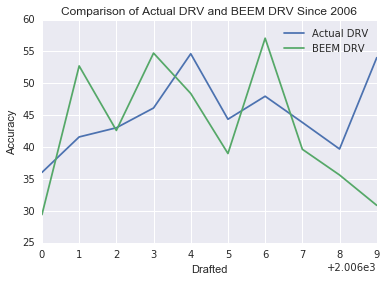

In [705]:
# Create plot of two models
df7 = pd.concat([actual, model], axis=1)
df7.plot.line()
plt.title('Comparison of Actual DRV and BEEM DRV Since 2006')
plt.ylabel('Accuracy')
plt.figure()

## Investigate out-of-sample prediction using the 2016 NBA Draft

In [706]:
# Import 2016 data and apply BEEM algorithm
df2016 = pd.DataFrame.from_csv('data.csv')
df2016 = df2016.loc[df2016['Drafted'] == 2016]
feature_cols = list(df2016[['Age', 'PTS', 'STL', 'BLK', 'AST', 'ATr', 'TOV', 'PF', 'OS2', 'IS2', 'WHr', 'TRB']])

X = df2016[feature_cols].fillna(np.mean(df2016[feature_cols]))
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=feature_cols)

pred = lr.predict(X)
df2016['LinearPred'] = pred
df2016['LinearErr'] = df2016['WSPredict'] - df2016['LinearPred']

feature_cols = list(df[['Move_adj', 'Vert_adj', 'Height', 'WHr', 'WtHr', 'OS2', 'D', 'IS2', 'P', 'FTr', 'LinearPred']])
X = df2016[feature_cols].fillna(0)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=feature_cols)

pred2 = clf.predict(X)
df2016['Prediction'] = pred2
df2016['SecondPred'] = df2016['LinearPred'] + df2016['Prediction']

g = df2016.groupby('Url')
last = list(df2016['Drafted'] - df2016['Season'])
weights = []
for item in last:
    if item == 0:
        weights.append(1)
    elif item == 1:
        weights.append(0.4)
    elif item == 2:
        weights.append(0.15)
    else:
        weights.append(0)
df2016['Weights'] = weights
df2016['PredxWeights'] = (df2016.SecondPred * df2016.Weights) / (g.Weights.transform("sum"))
df2016['FinalPred'] = df2016.groupby('Url').PredxWeights.transform('sum').fillna(df2016['SecondPred'])
        
df2016b = df2016[['Name', 'Pick', 'FinalPred']]
df2016b.groupby('Name').first().sort('Pick', ascending=True)

C:\Users\Matt\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:43: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Pick,FinalPred
Name,,
Ben Simmons,1.0,8.635635
Brandon Ingram,2.0,5.733951
Jaylen Brown,3.0,2.498946
Dragan Bender,4.0,2.919728
Kris Dunn,5.0,1.579928
Buddy Hield,6.0,1.814135
Jamal Murray,7.0,5.570182
Marquese Chriss,8.0,1.941425
Jakob Poeltl,9.0,5.304940
